**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Load packages:**

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sm
import math

from scipy import linalg
from scipy import optimize  
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display

from types import SimpleNamespace  

from copy import deepcopy
import time

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [7]:
# Parameters (symbolic)
alpha       = sm.symbols('alpha')
kappa       = sm.symbols('kappa')
v           = sm.symbols('v')
tau         = sm.symbols('tau')
w           = sm.symbols('w')
wtilde      = sm.symbols('wtilde')

# Variables (symbolic)
U           = sm.symbols('U')
C           = sm.symbols('C')
G           = sm.symbols('G')
L           = sm.symbols('L')

# Baseline parameters
alpha_val   = 0.5
kappa_val   = 1.0
w_val       = 1.0
v_val       = 1/(2*16**2)
tau_val     = 0.3
wtilde_val  = 0.70 

# Functions
utility           = sm.log(C**alpha * G**(1-alpha)) - v * L**2 / 2

budget_constraint = sm.Eq(C,kappa + (1- tau)*w*L)

after_tax_wage    = sm.Eq(wtilde, (1-tau)*w)

print(f'Ultily is')
display(utility)
print('Budget constraint is')
display(budget_constraint)
print('After tax wage is') 
display(after_tax_wage)

Ultily is


-L**2*v/2 + log(C**alpha*G**(1 - alpha))

Budget constraint is


Eq(C, L*w*(1 - tau) + kappa)

After tax wage is


Eq(wtilde, w*(1 - tau))

To verify the optimal labor supply, we a) insert the value for $\tilde{w}$ in the budget constaint b) isolate the expression for private consumption (c) and c) insert the expression for C in the utility function.

In [11]:
# a) insert w(1-tau) into budget constraint
budget_constraint1 = budget_constraint.subs((1-tau)*w, wtilde)
display(budget_constraint1)

# b) isolate C
budget_constraint1 = sm.solve(budget_constraint1,C)
display(budget_constraint1[0])

# c) insert into utility
utility1 = utility.subs(C,budget_constraint1[0])
display(utility1)

Eq(C, L*wtilde + kappa)

L*wtilde + kappa

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

The utility expression is then differentiated with respect to labor (L) and set equal to zero. The expression is subsequently solved for L, which is the expression for optimal labor supply $L^*(\tilde{w})$.

In [24]:
# Foc
foc = sm.diff(utility1,L)
foc = sm.simplify(foc)
print('The first order condition:')
display(foc)

# Foc is set equal to zero
foc = sm.Eq(foc,0)
print('The first order condition set equal to zero:')
display(foc)

sol = sm.solve(foc, L)
sol1 = sol[1]
print('optimal labor supply is')
display(sol[1])

The first order condition:


(-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa)

The first order condition set equal to zero:


Eq((-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa), 0)

optimal labor supply is


(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde)

The optimal labor supply is evaluated for $\tilde{w}=(1-\tau)w$ and $G \in \{1.0,2.0\}$. As evident from the plot below higher values of government consumption will result in a higher level of utility from working. However, the optimal working hours are unchanged.

The optimal level of labor supply:


Eq(L, (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

Utility with optimal level of labor:


log(G**(1 - alpha)*(kappa + (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v))**alpha) - (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))**2/(8*v*wtilde**2)

The optimal level of labor supply is:
15.30165022719559


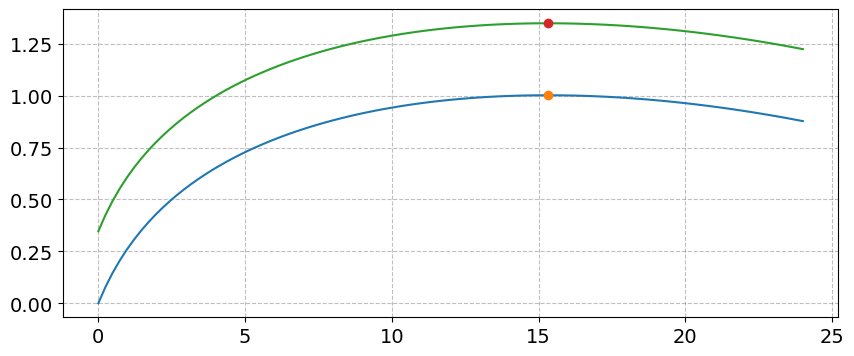

In [36]:
# Optimal level of L is converted to a equation
Optimal_L = sm.Eq(L,sol1)
print('The optimal level of labor supply:')
display(Optimal_L)

# The optimal level of L is substituted into the utility function
utility2 = utility1.subs(Optimal_L.lhs,Optimal_L.rhs)
print('Utility with optimal level of labor:')
display(utility2)

# lambdify function expressions which allows these expressions to be evaulated numerically
Lambda_sol1         = sm.lambdify(args=(alpha,kappa,v,wtilde),expr = sol1)
Lambda_utility1      = sm.lambdify(args=(alpha,kappa,v,G,wtilde,L),expr = utility1)
Lambda_utility2     = sm.lambdify(args=(alpha,kappa,v,G,wtilde),expr = utility2)

# Data to plot labor
L_vec = np.linspace(0,24,100)

Values_optimal_L = Lambda_sol1(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_val)

print('The optimal level of labor supply is:')
print(Values_optimal_L)

vec=[1,2]
for value in vec:
    Utility_vec_value = Lambda_utility1(alpha=alpha_val,kappa=kappa_val,v=v_val,G=value,wtilde=wtilde_val, L=L_vec)
    utility_optimal_L = Lambda_utility2(alpha=alpha_val,kappa=kappa_val,v=v_val,G=value,wtilde=wtilde_val)

    if value == 1:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
    ax.plot(L_vec,Utility_vec_value)

    # Plot the optimal value of labor as a dot
    ax.plot(Values_optimal_L,utility_optimal_L,'o')

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Optimal labor supply i.e., $L^{\star}(\tilde{w})$ is plottet against $w$.

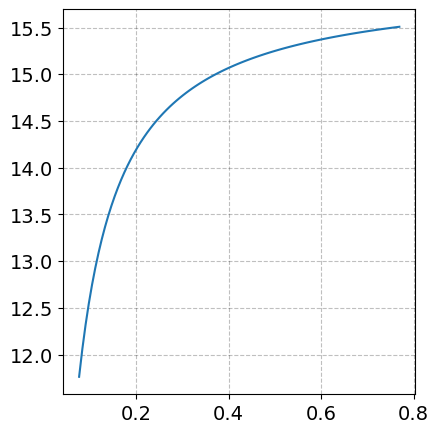

In [47]:
# Vector of possible after tax real wage values
wtilde_vec    = np.linspace(0.1,1,100)
w_vec         = 1 / (1 + tau_val) * wtilde_vec 

# A vector of optimal L is made
Optimal_L_vec = Lambda_sol1(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_vec)

# The result is plottet
fig           = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(w_vec,Optimal_L_vec)


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**G is plottet against $\tau$**

Eq(G, L*tau*w)

Eq(G, tau*w*(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

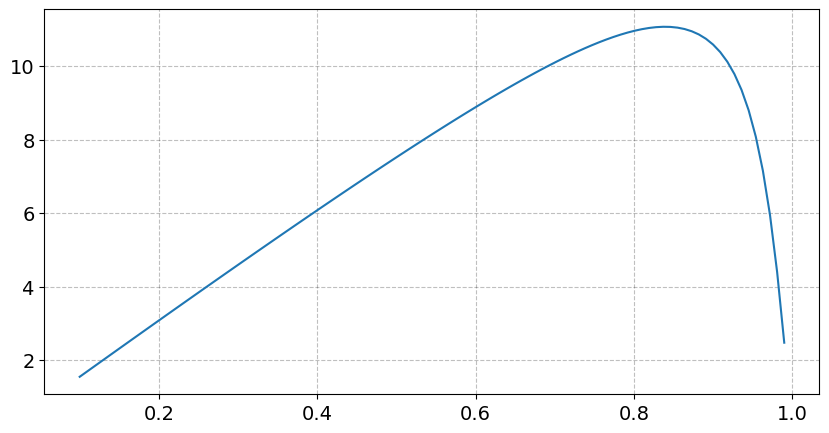

In [58]:
# Government budget is identified
govbudget = sm.Eq(G,tau*w*L)
display(govbudget)

# Optimal labor is substituted into the government budget
govbudget1 = govbudget.subs(L,Lstar.rhs)
display(govbudget1)

# The value of wtilde is substituted into the government budget
govbudget2 = govbudget1.subs(wtilde,(1-tau)*w)
display(govbudget2)

# The government budget function is lambdified
Lambda_govbudget2 = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=govbudget2.rhs)
gov_vec = Lambda_govbudget2(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

# Government budget is plottet against tau
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,gov_vec)

**Implied L is plottet against $\tau$**

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

Eq(L*tau*w, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

Eq(L, (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))

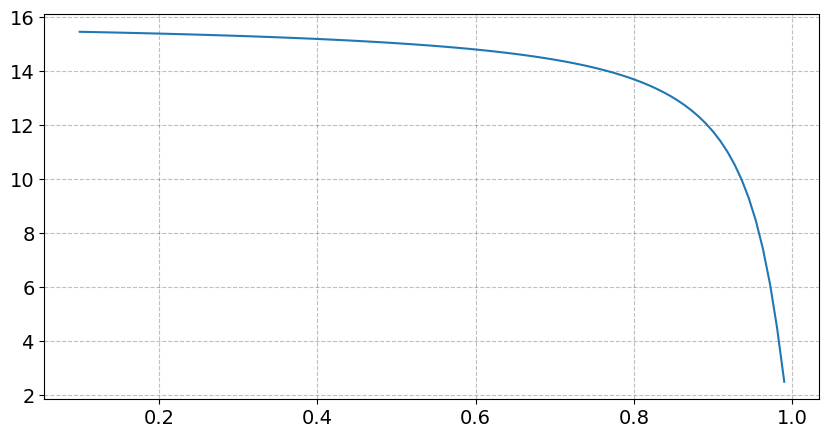

In [66]:
# The value of wtilde in government budget is substituted with (1-tau)*w
govbudget2 = govbudget2.subs(wtilde,(1-tau)*w)
display(govbudget2)

# Government budget is set equal to function value of government budget
Govbudget3 = govbudget2.subs(govbudget.lhs,govbudget.rhs)
display(Govbudget3)

# Implied L is identified
implied_L = sm.solve(Govbudget3,L)
implied_L1= sm.Eq(L,implied_L[0])
display(implied_L1)

# We define a vector of tau values
tau_vec = np.linspace(0.1,0.99,100)

# The function of implied L is lambdified
implied_L_lambdify = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=implied_L[0])
l_vec = implied_L_lambdify(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,l_vec)

**Worker utility is plottet against $\tau$**

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

-L**2*v/2 + log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(L*wtilde + kappa)**alpha)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + wtilde*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + (1 - tau)*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

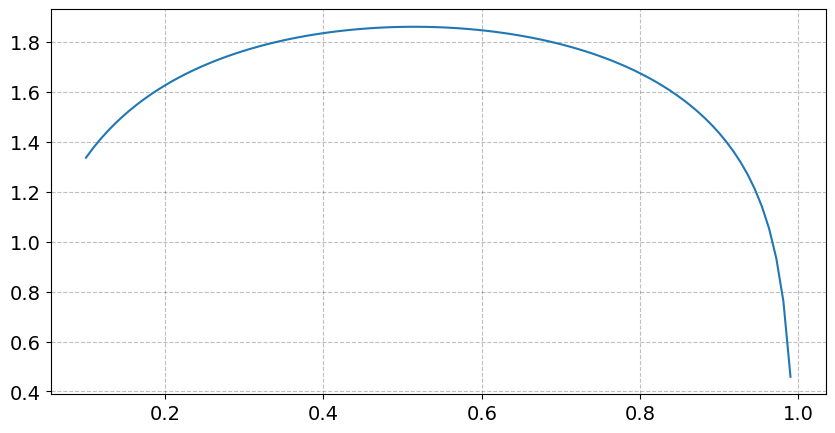

In [73]:
# Utility with budget constraint
display(utility1)
# Substitute utility with budget constraint into government budget
utility_sub1 = utility1.subs(govbudget_sub_subs.lhs,govbudget_sub_subs.rhs)
display(utility_sub1)

# The expression for optimal labor is substituted into the function
utility_sub2 = utility_sub1.subs(implied_L1.lhs,implied_L1.rhs)
display(utility_sub2)

# wtilde is substitued with (1-tau)*w
utility_sub3 = utility_sub2.subs(wtilde,(1-tau)*w)
display(utility_sub3)

# The expression is lambdified
Lambda_utility_sub3 = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=utility_sub3)
utility_vec = Lambda_utility_sub3(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

# Worker utility adjusted for G is plotted against tau
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,utility_vec)

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

0.51455078125
1.8591992502006924


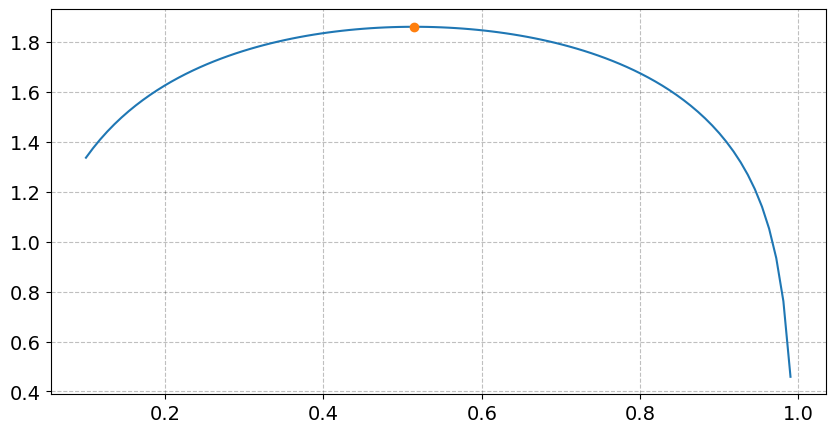

In [74]:
# Define objective function
obj = lambda tau : -utility_subs3_lambdify(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau)

# Define bounds 
bounds=[(0,0.99)]

# Define optimizer
opt = optimize.minimize(obj, 0.5, method='Nelder-Mead', bounds=bounds)
opt_tau = opt.x[0]
print(opt_tau)
print(-opt.fun)

#Plot the result
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,utility_vec)
ax.plot(opt_tau,-opt.fun,'o')

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [86]:
# TEST YOUR MODEL

# TO DO = ADD A PLOT MODULE TO THE MODEL CLASS (EVENTUELT)

from Exam2023 import OptimalTaxationModelClass

model = OptimalTaxationModelClass()

print(model.flag)

tau_star = model.solve_tau()

print(model.flag)

namespace(found_sol_tau=False, found_sol_G=False, found_sol_L=False, found_sol_C=False)
namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)


The more general preference formulation of the worker is formulated in the exam2023.py file. The model is firstly solved where $\sigma = 1.0001$ and $\rho = 1.0001$. This yields a optimal tax rate of 0.5 and a optimal goverment expenditure of 7.51. In comparison, when the model is solved for $\sigma = 1.5$ and $\rho = 1.5$ optimal government tax is unchanged on 0.5 whereas optimal government expenditure decreases to 4.86.  

In [87]:
model = OptimalTaxationModelClass()

tau_star_guess = 0.51455078125

G_star   = model.solve_G(tau_star_guess)

print(model.flag)

tau_vec = np.linspace(model.par.eps,1,100)

G_star_vec_1 = np.empty(100)
L_star_vec_1 = np.empty(100)

for i in range(np.size(tau_vec)):
    G_star_vec_1[i] = model.solve_G(tau_vec[i])
    L_star_vec_1[i] = model.solve_L(tau_vec[i],G_star_vec_1[i])

    if model.flag.found_sol_G == False:
        break

print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal guessed tax rate is: 0.51
Optimal government spending is: 7.71


In [88]:
model = OptimalTaxationModelClass()

model.par.sigma = 1.5
model.par.rho   = 1.5

tau_star_guess = 0.51455078125

G_star   = model.solve_G(tau_star_guess)

print(model.flag)

tau_vec = np.linspace(model.par.eps,1,100)

G_star_vec_2 = np.empty(100)
L_star_vec_2 = np.empty(100)

for i in range(np.size(tau_vec)):
    G_star_vec_2[i] = model.solve_G(tau_vec[i])
    L_star_vec_2[i] = model.solve_L(tau_vec[i],G_star_vec_2[i])

    if model.flag.found_sol_G == False:
        break

print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal guessed tax rate is: 0.51
Optimal government spending is: 4.98


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [89]:
# Param 1
model = OptimalTaxationModelClass()

tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

print(model.flag)

print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

tau_star1 = tau_star
G_star1   = G_star
L_star1   = L_star

namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal tax rate is: 0.51
Optimal government spending is: 7.71
Optimal labor supply is: 14.99
Optimal consumption is: 8.28


In [90]:
# Param 2
model = OptimalTaxationModelClass()

model.par.sigma = 1.5
model.par.rho   = 1.5

tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

print(model.flag)

print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

tau_star2 = tau_star
G_star2   = G_star
L_star2   = L_star

namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal tax rate is: 0.46
Optimal government spending is: 4.57
Optimal labor supply is: 9.89
Optimal consumption is: 6.32


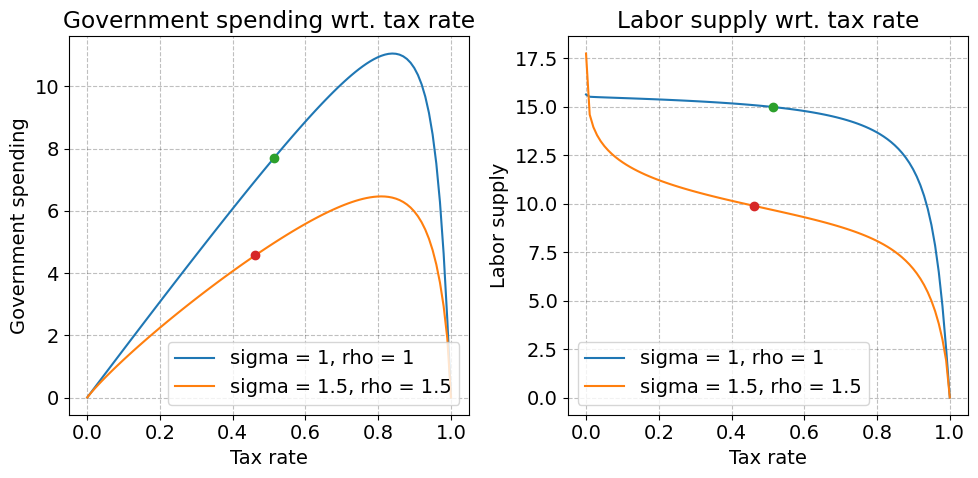

In [83]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)

# Government spending
ax1.set_title('Government spending wrt. tax rate')
ax1.set_xlabel('Tax rate')
ax1.set_ylabel('Government spending')
ax1.plot(tau_vec,G_star_vec_1, label = 'sigma = 1, rho = 1')
ax1.plot(tau_vec,G_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax1.plot(tau_star1,G_star1,'o')
ax1.plot(tau_star2,G_star2,'o')

ax1.legend()

# Labor supply
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Labor supply wrt. tax rate')
ax2.set_xlabel('Tax rate')
ax2.set_ylabel('Labor supply')
ax2.plot(tau_vec,L_star_vec_1, label = 'sigma = 1, rho = 1')
ax2.plot(tau_vec,L_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax2.plot(tau_star1,L_star1,'o')
ax2.plot(tau_star2,L_star2,'o')
ax2.legend()

plt.tight_layout()


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [91]:
#Parameters
eta=0.5
w=1
kappa=1

kappa_vec = [1,2]

#Profit function
def calc_profit(l,kappa):
    p =  kappa*l**(-eta)
    profit =  p*l-w*l
    return profit 

for kappa in kappa_vec:
    l_guess=0.5
    obj = lambda l: -calc_profit(l[0],kappa)
    res = optimize.minimize(obj,l_guess,method='Nelder-Mead') 
    opt_l = res.x
    print(f'Numerical solution is {opt_l} for kappa={kappa}')
    l=(((1-eta)*kappa)/w)**(1/eta)
    print(f'Analytical solution is {[l]} for kappa={kappa}')
    print(f'Profit is {calc_profit(l,kappa)} for kappa={kappa}')

Numerical solution is [0.25] for kappa=1
Analytical solution is [0.25] for kappa=1
Profit is 0.25 for kappa=1
Numerical solution is [1.] for kappa=2
Analytical solution is [1.0] for kappa=2
Profit is 1.0 for kappa=2


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [92]:
# PLug delta ind og find samlet ex post nytte
def calc_opt_l(eta,kappa,w):
   return (((1-eta)*kappa)/w)**(1/eta)

def calc_profit_adj(l,kappa,iota):
    profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
    return profit 

def simulate(K=10000, Delta=0.05, follow_adjustment_rule=False):

    """ Takes as input the number of k values, the adjustment cost and whether to follow the adjustment rule or not.
    Returns the simulated values of kappa, labor supply, profit and discounted total value of profits. """

    np.random.seed(2000)
    #Simulate kappa values from starting point with K steps, do that 120 times.
    #a. allocate
    par = SimpleNamespace()
    par.K = K
    par.T = 120

    par.eta=0.5
    par.w=1
    par.rho=0.9
    par.sigma=0.1
    par.iota = 0.1
    par.R=(1+0.01)**(1/12)
    par.R_new=(1+0.10)
    par.Delta=Delta
    par.Delta_vec=np.ones(par.K)*par.Delta

    sim = SimpleNamespace()
    sim.kappa = np.zeros((par.T,par.K))
    sim.kappa_ini = np.ones(par.K)

    sim.l = np.zeros((par.T,par.K))
    sim.l_ini=np.zeros(par.K)

    sim.h = np.zeros((1,par.K))
    sim.profit=np.zeros((par.T,par.K))

    for t in range(par.T):
        #i. Lagged kappa values
        if t == 0:
            sim.kappa[t,:] = np.exp(par.rho* np.log10(sim.kappa_ini) + np.random.normal(-0.5*par.sigma*par.sigma,par.sigma,size=par.K))  
        else:
            sim.kappa[t,:] = np.exp(par.rho* np.log10(sim.kappa[t-1,:]) + np.random.normal(-0.5*par.sigma*par.sigma,par.sigma,size=par.K))

        # ii. labor supply
        sim.l[t,:] = calc_opt_l(par.eta,sim.kappa[t,:],par.w) 
        # iii profit
        sim.profit[t,:] = calc_profit_adj(sim.l[t,:],sim.kappa[t,:],par.iota) #adjustment cost

        if follow_adjustment_rule == True:
            if t == 0:
                sim.l[t,:]=np.where(np.abs(sim.l[t,:]-sim.l_ini) < par.Delta, sim.l_ini, sim.l[t,:])
                sim.profit[t,:] = np.where(np.abs(sim.l[t,:]-sim.l_ini) < par.Delta, 0, sim.profit[t,:])
            else: 
                sim.l[t,:]=np.where(np.abs(sim.l[t,:]-sim.l[t-1,:]) < par.Delta, sim.l[t-1,:], sim.l[t,:])
                sim.profit[t,:] = np.where(np.abs(sim.l[t,:]-sim.l[t-1,:]) < par.Delta, calc_profit_adj(sim.l[t,:],sim.kappa[t,:],0), sim.profit[t,:])
                
        # iii. profit
        #sim.profit[t,:] = calc_profit_adj(sim.l[t,:],sim.kappa[t,:],par.iota) #adjustment cost
        # iv. total value of profits
        sim.h += par.R**(-t) * (sim.profit[t,:])
    return np.mean(sim.h)

In [93]:
K_vec = [1, 10, 100, 1000, 10000, 100000]
for i in K_vec:
    res=simulate(i,0.05,False)
    print(f'Ex-post value of profit for each kappa series is {res} for K={i}')

Ex-post value of profit for each kappa series is 18.924374307437855 for K=1
Ex-post value of profit for each kappa series is 17.81442080651005 for K=10
Ex-post value of profit for each kappa series is 17.30808221809202 for K=100
Ex-post value of profit for each kappa series is 17.3789087256903 for K=1000
Ex-post value of profit for each kappa series is 17.347838953630266 for K=10000
Ex-post value of profit for each kappa series is 17.347564758356512 for K=100000


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [94]:
res=simulate(10000,0.05,False)
print(f'Discounted value of profits without adjustment rule {res} for K={10000}')
res=simulate(10000,0.05,True)
print(f'Discounted value of profits with adjustment rule {res} for K={10000}')

Discounted value of profits without adjustment rule 17.347838953630266 for K=10000
Discounted value of profits with adjustment rule 24.00098163073346 for K=10000


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [95]:
obj = lambda Delta: -simulate(10000, Delta, True)
bounds=[(0,2)]
opt = optimize.minimize(obj, 0.1, method='Nelder-Mead', bounds=bounds)
opt_Delta = opt.x[0]
print(opt_Delta)
print(simulate(10000, opt_Delta, True))

C:\Users\MUHH\AppData\Local\Temp\1\ipykernel_42380\753590557.py:6: RuntimeWarning: divide by zero encountered in power
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
C:\Users\MUHH\AppData\Local\Temp\1\ipykernel_42380\753590557.py:6: RuntimeWarning: invalid value encountered in multiply
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)


0.2085156250000004
28.04355237556108


In [96]:
K=10000
Delta=0.05

np.random.seed(2000)
#Simulate kappa values from starting point with K steps, do that 120 times.
#a. allocate
par = SimpleNamespace()
par.K = K
par.T = 8

par.eta=0.5
par.w=1
par.rho=0.9
par.sigma=0.1
par.iota = 0.1
par.R=(1+0.01)**(1/12)
par.R_new=(1+0.10)

par.m_min = 0
par.m_max = 2
par.Nm = 100
eta=0.5
w=1

sim = SimpleNamespace()
sim.kappa = np.zeros((par.T,par.K))
sim.kappa_ini = np.ones(par.K)

sim.l = np.zeros((par.T,par.K))
sim.l_ini=np.zeros(par.K)

sim.h = np.zeros((1,par.K))
sim.profit=np.zeros((par.T,par.K))

def calc_profit_adj(l,kappa,iota):
    profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
    return profit 

def calc_opt_l(eta,kappa,w):
   return (((1-eta)*kappa)/w)**(1/eta)

def solve_last_period(par):

    # a. allocate
    k_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    l_func = np.empty(par.Nm)

    # b. solve for each value of the grid, meaning that for each value of cash in hand, we find the optimal consumption and value of the value function.
    #Normally that would just be done once for each problem, but we want to use it to create an interpolater.
    for i,k in enumerate(k_grid):

        # i. objective
        obj = lambda l: -calc_profit_adj(l[0],k,par.iota)

        # ii. optimizer
        x0 = 0.2 # initial value
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=[(par.m_min,par.m_max)])

        # iii. save
        v_func[i] = -result.fun
        l_func[i] = result.x
        
    return k_grid,v_func,l_func

k2_grid,v2_func,l2_func = solve_last_period(par)

#IMPORTANT: We construct an interpolater called v2_func_interp using the interpolater function from scipy.interpolate.
#The interpolater takes as arguments the grid and the values of the function on the grid which we found before.
v2_func_interp = interpolate.RegularGridInterpolator([k2_grid],v2_func,
    bounds_error=False,fill_value=None)

#NB: kappa_grid is a grid of kappas that represent the distribution of expected values
kappa_grid = np.linspace(par.m_min,par.m_max,par.Nm)

#Note that the v_plus_interp is not a specific interpolater, but a placeholder for the one we create later called v2_func_interp
def v(l,k,iota,v_plus_interp):
    
    # a. expected value
    v_plus = 0.0
    for kappa in kappa_grid:
            
        # i. next period value function evaluated using interpolation, depends on the cash on hand, which depends on income shock
        v_plus_now = v_plus_interp([kappa])[0]
        
        # ii. the next period value is added to the expected value
        v_plus += v_plus_now
    #iii. average value is found
    v_plus/=par.Nm #average value
    # b. total value in current period is found
    return calc_profit_adj(l,kappa,par.iota) + par.R*v_plus


#v_plus_interp is still not a specific interpolatar, but a placeholder for the one we create later called v_plus_func_interp
#Note that the interpolater is callable, meaning that we can call it with a value of m and it will return the interpolated function value at that point.
def solve_single_period(par,v_plus_interp):

    # a. allocate
    k_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    l_func = np.empty(par.Nm)
    
    # b. solve
    for i,k in enumerate(k_grid):
        
        # i. objective
        obj = lambda l: -v(l[0],k,par.iota,v_plus_interp)
        
        # ii. solve
        x0 = k/2 # initial guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=[(par.m_min,par.m_max)])
        
        # iv. save
        v_func[i] = -result.fun
        l_func[i] = result.x[0]
     
    return k_grid,v_func,l_func

def solve_many_periods(par):
    
    t0 = time.time()
    
    # a. allocate
    sol = SimpleNamespace()
    sol.k = np.zeros((par.T,par.Nm))
    sol.v = np.zeros((par.T,par.Nm))
    sol.l = np.zeros((par.T,par.Nm))
    
    # b. iterate
    for t in reversed(range(par.T)):
        
        t0_ = time.time()
        
        if t == par.T-1:
            
            sol.k[t,:],sol.v[t,:],sol.l[t,:] = solve_last_period(par)
            
        else:
    
            # i. construct interpolator
            #Note: The interpolater is updated in each period, based on the optimal cash on hand and value function in the next period (the one which was just solved).
            v_plus_interp = interpolate.RegularGridInterpolator([sol.k[t+1,:]],sol.v[t+1,:],
                bounds_error=False,fill_value=None)
    
            # ii. solve period
            sol.k[t,:],sol.v[t,:],sol.l[t,:] = solve_single_period(par,v_plus_interp)
        
        print(f'period {t} solved in {time.time()-t0_:5.1f} secs')
        
    print(f'model solved in {time.time()-t0:5.1f} secs')
    
    return sol

par.T = 8
sol = solve_many_periods(par)

C:\Users\MUHH\AppData\Local\Temp\1\ipykernel_42380\2296250577.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
C:\Users\MUHH\AppData\Local\Temp\1\ipykernel_42380\2296250577.py:36: RuntimeWarning: invalid value encountered in double_scalars
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)


period 7 solved in   0.2 secs
period 6 solved in  15.0 secs
period 5 solved in  14.2 secs
period 4 solved in  14.4 secs
period 3 solved in  14.4 secs
period 2 solved in  14.8 secs
period 1 solved in  11.1 secs
period 0 solved in  11.6 secs
model solved in  95.7 secs


In [97]:
l_interps = []
for t in range(par.T):
    #This interpolater is a consumption interpolator, which builds on the solutions from above
    l_interp = interpolate.RegularGridInterpolator([sol.k[t,:]],sol.l[t,:],
        bounds_error=False,fill_value=None)
    l_interps.append(l_interp)


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

We first define the Griewank function. We then plot the function and observe that there seem to be a global minima in $(x_1,x_2)=(0.0)$, where its function value is 0.

0.0


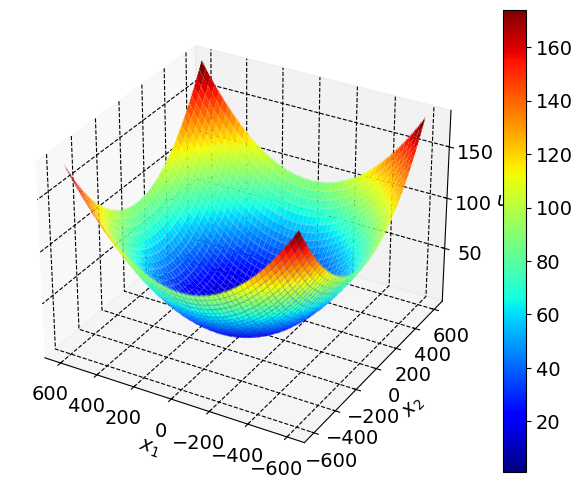

In [5]:
#Define the griwank function
def griewank(x):
    return _griewank(x[0], x[1])

def _griewank(x1, x2):
    A = x1 ** 2 / 4000 + x2 ** 2 / 4000
    B = np.cos(x1 / np.sqrt(1)) * np.cos(x2 / np.sqrt(2))
    return A - B + 1

#Print the value of the griwank function at the point (0,0)
print(griewank([0, 0]))

#Plot the griwank function
N = 5000  # numbers in grid
lower_bound = -600  # lower bound
upper_bound = 600  # upper bound

# a. grids
x1_vec = np.linspace(lower_bound, upper_bound, N)
x2_vec = np.linspace(lower_bound, upper_bound, N)
x1_grid, x2_grid = np.meshgrid(x1_vec, x2_vec, indexing='ij')
griewank_grid = _griewank(x1_grid, x2_grid)

# b. main
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cs = ax.plot_surface(x1_grid, x2_grid, griewank_grid, cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

We then proceed to define three functions: collect(), contour() and convergence(). Each can be used in the following code-block, where the refined global optimizer is run.

* collect() is run every time the optimizer in solve_multistart() is run. It has two features. First, it collects all the set of trial values $(x_1,x_2)$ that is tried and the resulting function of the griewank function and appends them to lists. Second, it counts the number of evaluations that is done for each time solve_multistart() is called.

* contour() creates a contour plot of the griewank function and plots the set of input values and function value, that is returned each time the optimizer in solve_multistart() is called. It is printed if "print_contour=True" is inputted into the solve_multistart()-function.

* convergence() draws a graph with two subgraphs, one for each input. It plots how the effective initial guesses varies with the iteration counter. It is printed if "print_convergence=True" is inputted into the solve_multistart()-function.

Note that the "iteration counter" refers to the value of $k$. This is not the same as the variable "nit". "nit" counts the total number of evaluations, which is different from $k$ for a given call to solve_multistart() because multiple evaluations are done in each iteration.

In [7]:
# The function is used to collect information while the optimizer is run
def collect(x): 
    # globals used to keep track across iterations
    global nit 
    global x1s
    global x2s
    global fs

    # a. initialize list
    if nit == 0:
        x1s = [x[0]]
        x2s = [x[1]]
        fs = [griewank(x)]

    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(griewank(x))

    # c. increment number of evaluations
    nit += 1

# The function is used to plot a contour plot
def contour():
    global nit
    global x1s
    global x2s

    # a. contour plot
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    levels = [1e-6, 5 * 1e-6, 1e-5, 5 * 1e-5, 1e-4, 5 * 1e-4, 1e-3, 5 * 1e-3, 1e-2, 5 * 1e-2, 1, 2, 4, 6, 8, 12, 16, 20]
    cs = ax.contour(x1_grid, x2_grid, griewank_grid, levels=levels, cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s, x2s, '-o', ms=4, color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    fig.tight_layout()

# The function is used to plot the convergence of the optimizer, each point represents a new iteration
def convergence(K,x0s):
    global nit
    k_grid = np.arange(K)
    x0s = np.array(x0s)

    # Create the first subplot for x0s[:,0]
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Plot x0s[:,0]
    ax[0].plot(k_grid, x0s[:, 0], '-o', ms=1, color='black')
    ax[0].set_xlabel('k-value')
    ax[0].set_ylabel('x0s[:,0]')

    # Create the second subplot for x0s[:,1]
    ax[1].plot(k_grid, x0s[:, 1], '-o', ms=1, color='black')
    ax[1].set_xlabel('k-value')
    ax[1].set_ylabel('x0s[:,1]')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()    

The solve_multistart 

In [6]:
# We use multistart to draw random starting values
def solve_multistart(K=1000, K_warm=10, tol=1e-8,lower_bound=-600, upper_bound=600,refined=True,print_contour=False,print_convergence=False):
    """ Solves a function using multistart optimization

    args:
        K (int): number of starting points
        K_warm (int): number of warmup iterations
        tol (float): tolerance level
        lower_bound (float): lower bound for the starting values
        upper_bound (float): upper bound for the starting values
        refined (bool): whether to use refined starting values
        print_contour (bool): whether to print a contour plot
        print_convergence (bool): whether to print a convergence plot
   
    """

    # a. initialize
    np.random.seed(2000)
    x0s = np.empty((K, 2))
    xs = np.empty((K, 2))
    nit = 0

    fopt = np.inf
    xopt = np.nan


    for k in range(K):
        # Draw random starting point
        x0s[k, :] = np.random.uniform(lower_bound, upper_bound, 2)
        if k >= K_warm and refined:
            chi = 0.5 * 2 / (1 + np.exp((k - K_warm) / 100))
            x0s[k, :] = chi * x0s[k, :] + (1 - chi) * xopt

        # a. optimize
        result = optimize.minimize(griewank, x0s[k, :], method='BFGS', callback=collect, tol=tol, options={'disp': False})
        xs[k, :] = result.x
        f = result.fun

        # b. update
        if f < fopt:
            fopt = f
            xopt = xs[k, :]

        if fopt < tol:
            break

    print(xopt, fopt, nit)
    if print_contour:
        contour()
    if print_convergence:
        convergence(K,x0s=x0s)
    return result,x0s

[-12.56009041   8.87688873] 0.05917817705510919 0


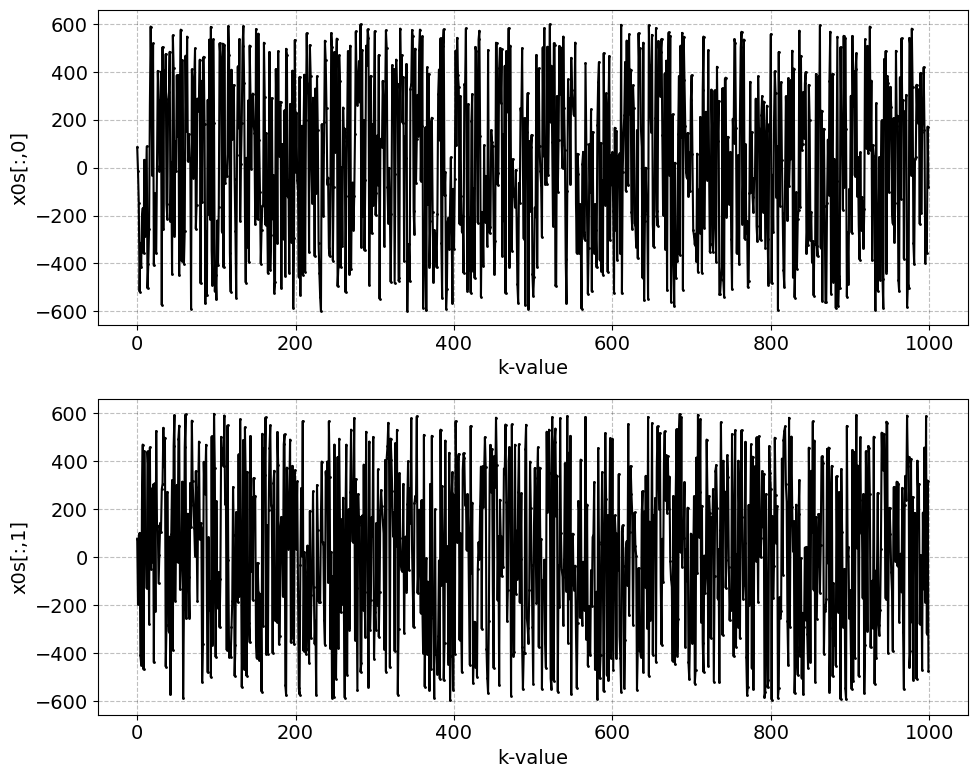

[-7.50683665e-09 -3.91694699e-09] 0.0 0


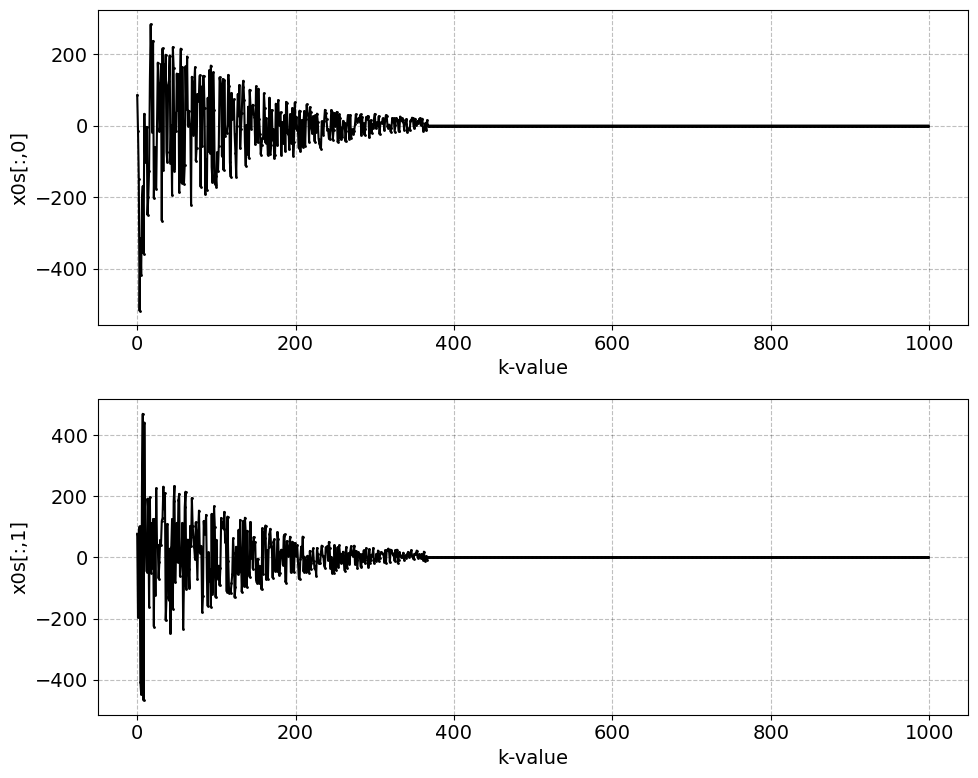

In [8]:
nit=0
res=solve_multistart(refined=False, print_convergence=True)
nit=0
res=solve_multistart(refined=True, print_convergence=True)

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

It appears to be the case, that a $\underline{K} = 100$ results in a slower convergence (1.4 sek) in comparison to a $\underline{K} = 100$ (1.7 sek). The convergence occurs at a value around $\underline{K} = 400$ and a guess of $\underline{K} = 100$ does not speed up the process of convergence.

In [9]:
nit=0
t0 = time.time()
res=solve_multistart(K_warm=10)
print(f'model solved in {time.time()-t0:5.1f} secs')
nit=0
t0 = time.time()
res=solve_multistart(K_warm=100)
print(f'model solved in {time.time()-t0:5.1f} secs')

[-7.50683665e-09 -3.91694699e-09] 0.0 0
model solved in   2.0 secs
[-3.97123331e-09 -8.42323954e-09] 0.0 0
model solved in   2.0 secs


[-3.97123331e-09 -8.42323954e-09] 0.0 0


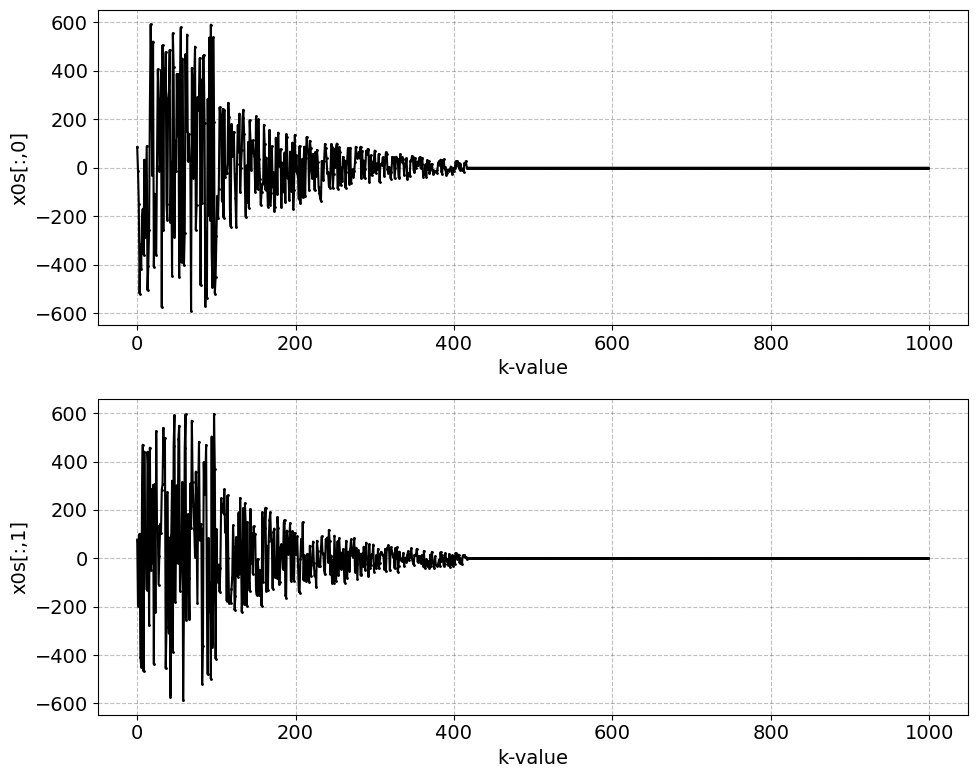

In [10]:
nit=0
res=solve_multistart(K_warm=100, print_convergence=True)